## Same cut as get ratio

Display pxp - pxn plots for different gamma values (z polarization)

In [34]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [35]:
# Install necessary packages if not already installed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install necessary packages
install_package("plotly")
install_package("nbformat")
install_package("ipywidgets")

# Set plotly renderer to static HTML to avoid Jupyter display issues
import plotly.io as pio
pio.renderers.default = "browser"

In [36]:
# Get SMSIMDIR environment variable
smdir = os.getenv('SMSIMDIR')


Calculate z polarization first

In [37]:
pols = ["znp", "zpn"]  # Z polarization uses znp and zpn
count_px_pbiggger = 0
count_px_nbiggger = 0
bmin = 5
bmax = 10
targets = ["Pb208", "Sn124", "Sn112", "Xe130"]  # Four target nuclei
R_list = []
gammas = ["050", "060", "070", "080"]

# Initialize data storage dictionaries
pxp_values = {gamma: [] for gamma in gammas}
pxn_values = {gamma: [] for gamma in gammas}
phi_values = {gamma: [] for gamma in gammas}

# Store 3D momentum data
momentum_data = {
    'proton': {target: {gamma: {'px': [], 'py': [], 'pz': []} for gamma in gammas} for target in targets},
    'neutron': {target: {gamma: {'px': [], 'py': [], 'pz': []} for gamma in gammas} for target in targets}
}

# Total 3D momentum data (all targets and gammas)
total_momentum_data = {
    'proton': {'px': [], 'py': [], 'pz': []},
    'neutron': {'px': [], 'py': [], 'pz': []}
}

for target in targets:
    for gamma in gammas:
        for b in range(bmin, bmax + 1):  # Z pol uses b iteration
            for p in pols:
                # Build file path - Z pol uses b_discrete directory
                folder = os.path.join(smdir, f"QMDdata/rawdata/z_pol/b_discrete/d+{target}E190g{gamma}{p}/")
                filename = f"dbreakb{b:02d}.dat"  # Z pol file naming convention
                filepath = os.path.join(folder, filename)

                # Check if file exists and open
                if not os.path.isfile(filepath):
                    print(f"Warning: File not found: {filepath}")
                    continue

                with open(filepath, 'r') as inputfile:
                    # Read file header
                    info = inputfile.readline().strip()
                    header = inputfile.readline().strip()

                    # Read data
                    for line in inputfile:
                        data = line.split()
                        if len(data) < 7:
                            continue
                        eventNo = int(data[0])

                        # Z pol has event number filtering
                        if eventNo >= 10000.0 * b / bmax:
                            continue

                        pxp_orig, pyp_orig, pzp_orig = map(float, data[1:4])
                        pxn_orig, pyn_orig, pzn_orig = map(float, data[4:7])

                        # Create initial 3D vectors using numpy arrays
                        pp_orig = np.array([pxp_orig, pyp_orig, pzp_orig], dtype=float)
                        pn_orig = np.array([pxn_orig, pyn_orig, pzn_orig], dtype=float)

                        # Calculate azimuthal angle (phi) of sum momentum
                        vec_sum_orig = pp_orig + pn_orig
                        phi_for_rotation = np.arctan2(vec_sum_orig[1], vec_sum_orig[0])

                        # First condition check - Z pol uses pz conditions
                        condition1_part1 = (pzp_orig + pzn_orig) > 1150
                        condition1_part2 = (np.pi - abs(phi_for_rotation)) < 0.5
                        condition1_part3 = abs(pzp_orig - pzn_orig) < 150
                        condition1_part4 = (pxp_orig + pxn_orig) < 200
                        condition1_part5 = (vec_sum_orig[0]**2 + vec_sum_orig[1]**2) > 2500
                        
                        if condition1_part1 and condition1_part2 and condition1_part3 and condition1_part4 and condition1_part5:
                            # Rotation operation
                            angle_rad = -phi_for_rotation
                            cos_a = np.cos(angle_rad)
                            sin_a = np.sin(angle_rad)
                            
                            R_z = np.array([
                                [cos_a, -sin_a, 0],
                                [sin_a,  cos_a, 0],
                                [0,      0,     1]
                            ])

                            # Rotate original momentum vectors
                            pp_rotated = R_z @ pp_orig
                            pn_rotated = R_z @ pn_orig

                            # Update momentum components
                            pxp, pyp, pzp = pp_rotated[0], pp_rotated[1], pp_rotated[2]
                            pxn, pyn, pzn = pn_rotated[0], pn_rotated[1], pn_rotated[2]

                            # Store rotated momentum data (for Pb208 compatibility)
                            if target == "Pb208":
                                vector_total_rotated = np.array([pxp + pxn, pyp + pyn, pzp + pzn])
                                phi_to_store = np.arctan2(vector_total_rotated[1], vector_total_rotated[0])
                                
                                phi_values[gamma].append(phi_to_store)
                                pxp_values[gamma].append(pxp)
                                pxn_values[gamma].append(pxn)
                            
                            # Store 3D momentum data (all targets)
                            momentum_data['proton'][target][gamma]['px'].append(pxp)
                            momentum_data['proton'][target][gamma]['py'].append(pyp)
                            momentum_data['proton'][target][gamma]['pz'].append(pzp)
                            
                            momentum_data['neutron'][target][gamma]['px'].append(pxn)
                            momentum_data['neutron'][target][gamma]['py'].append(pyn)
                            momentum_data['neutron'][target][gamma]['pz'].append(pzn)
                            
                            # Store total 3D momentum data
                            total_momentum_data['proton']['px'].append(pxp)
                            total_momentum_data['proton']['py'].append(pyp)
                            total_momentum_data['proton']['pz'].append(pzp)
                            
                            total_momentum_data['neutron']['px'].append(pxn)
                            total_momentum_data['neutron']['py'].append(pyn)
                            total_momentum_data['neutron']['pz'].append(pzn)

In [38]:
# Create output directory if not exists
import os
if not os.path.exists('output'):
    os.makedirs('output')
    print("Created output directory")

print(f"Data processing completed!")

Data processing completed!


In [39]:
gamma_label = [0.5, 0.6, 0.7, 0.8]

print(gamma_label[0])
print(gamma_label[1])

0.5
0.6


In [40]:
# Use Plotly to create interactive 3D momentum distributions
def plot_interactive_3d_momentum():
    """Plot interactive 3D momentum distributions with Plotly."""
    
    # Color settings
    colors = ['blue', 'red', 'green', 'orange']
    gamma_labels = [0.5, 0.6, 0.7, 0.8]
    
    # Create subplots: 4 rows x 2 cols for 4 targets, each is 3D
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=['Proton - Pb208', 'Neutron - Pb208',
                       'Proton - Sn124', 'Neutron - Sn124',
                       'Proton - Sn112', 'Neutron - Sn112',
                       'Proton - Xe130', 'Neutron - Xe130'],
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
               [{'type': 'scatter3d'}, {'type': 'scatter3d'}],
               [{'type': 'scatter3d'}, {'type': 'scatter3d'}],
               [{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )
    
    # For each target and particle type
    subplot_positions = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 1), (4, 2)]
    target_particle_combinations = [
        ('Pb208', 'proton'), ('Pb208', 'neutron'),
        ('Sn124', 'proton'), ('Sn124', 'neutron'),
        ('Sn112', 'proton'), ('Sn112', 'neutron'),
        ('Xe130', 'proton'), ('Xe130', 'neutron')
    ]
    
    for idx, ((target, particle_type), (row, col)) in enumerate(zip(target_particle_combinations, subplot_positions)):
        for gamma_idx, gamma in enumerate(gammas):
            px_data = momentum_data[particle_type][target][gamma]['px']
            py_data = momentum_data[particle_type][target][gamma]['py']
            pz_data = momentum_data[particle_type][target][gamma]['pz']
            
            if len(px_data) > 0:
                # Sample data if too many points
                sample_size = min(1500, len(px_data))
                if len(px_data) > sample_size:
                    indices = np.random.choice(len(px_data), sample_size, replace=False)
                    px_sample = [px_data[i] for i in indices]
                    py_sample = [py_data[i] for i in indices]
                    pz_sample = [pz_data[i] for i in indices]
                else:
                    px_sample, py_sample, pz_sample = px_data, py_data, pz_data
                
                # Add scatter trace
                fig.add_trace(
                    go.Scatter3d(
                        x=px_sample,
                        y=py_sample,
                        z=pz_sample,
                        mode='markers',
                        marker=dict(
                            size=3,
                            color=colors[gamma_idx],
                            opacity=0.7
                        ),
                        name=f'{target}-{particle_type}-gamma={gamma_labels[gamma_idx]}',
                        showlegend=True if idx == 0 else False
                    ),
                    row=row, col=col
                )
    
    # Update layout
    fig.update_layout(
        title={
            'text': 'Interactive 3D Momentum Distribution - Z Polarization (rotatable & zoomable)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        height=1600,  # Increased height for 4 rows
        width=1200,
        legend=dict(
            x=1.02,
            y=1,
            traceorder="normal",
            font=dict(size=10)
        )
    )
    
    # Update axis labels for all 8 subplots
    for i in range(1, 9):
        fig.update_scenes(
            xaxis_title="Px (MeV/c)",
            yaxis_title="Py (MeV/c)", 
            zaxis_title="Pz (MeV/c)",
            selector=dict(type="scene")
        )
    
    fig.show()
    fig.write_html("output/zpol_interactive_3d_momentum_by_target.html")
    print("Interactive 3D plot saved to: output/zpol_interactive_3d_momentum_by_target.html")
    
    return fig

# Execute interactive plotting
interactive_fig = plot_interactive_3d_momentum()

正在现有的浏览器会话中打开。
Interactive 3D plot saved to: output/zpol_interactive_3d_momentum_by_target.html


In [41]:
# Create total interactive 3D momentum distribution plot
def plot_total_interactive_3d_momentum():
    """Plot total proton and neutron interactive 3D momentum distribution"""
    
    # Create subplots: 1 row x 2 cols
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Total Proton 3D Momentum', 'Total Neutron 3D Momentum'],
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        horizontal_spacing=0.1
    )
    
    # Proton data
    px_p = total_momentum_data['proton']['px']
    py_p = total_momentum_data['proton']['py']
    pz_p = total_momentum_data['proton']['pz']
    
    if len(px_p) > 0:
        # Sample data if too many
        sample_size = min(3000, len(px_p))
        if len(px_p) > sample_size:
            indices = np.random.choice(len(px_p), sample_size, replace=False)
            px_sample = [px_p[i] for i in indices]
            py_sample = [py_p[i] for i in indices]
            pz_sample = [pz_p[i] for i in indices]
        else:
            px_sample, py_sample, pz_sample = px_p, py_p, pz_p
        
        # Calculate momentum magnitude for coloring
        momentum_magnitude = np.sqrt(np.array(px_sample)**2 + np.array(py_sample)**2 + np.array(pz_sample)**2)
        
        # Add proton scatter plot
        fig.add_trace(
            go.Scatter3d(
                x=px_sample,
                y=py_sample,
                z=pz_sample,
                mode='markers',
                marker=dict(
                    size=4,
                    color=momentum_magnitude,
                    colorscale='Viridis',
                    opacity=0.7,
                    colorbar=dict(
                        title="Momentum (MeV/c)",
                        x=0.45,
                        len=0.8
                    )
                ),
                name='Proton',
                hovertemplate='<b>Proton</b><br>' +
                            'Px: %{x:.1f} MeV/c<br>' +
                            'Py: %{y:.1f} MeV/c<br>' +
                            'Pz: %{z:.1f} MeV/c<br>' +
                            '|P|: %{marker.color:.1f} MeV/c<extra></extra>'
            ),
            row=1, col=1
        )
    
    # Neutron data
    px_n = total_momentum_data['neutron']['px']
    py_n = total_momentum_data['neutron']['py']
    pz_n = total_momentum_data['neutron']['pz']
    
    if len(px_n) > 0:
        # Sample data if too many
        sample_size = min(3000, len(px_n))
        if len(px_n) > sample_size:
            indices = np.random.choice(len(px_n), sample_size, replace=False)
            px_sample = [px_n[i] for i in indices]
            py_sample = [py_n[i] for i in indices]
            pz_sample = [pz_n[i] for i in indices]
        else:
            px_sample, py_sample, pz_sample = px_n, py_n, pz_n
        
        # Calculate momentum magnitude for coloring
        momentum_magnitude = np.sqrt(np.array(px_sample)**2 + np.array(py_sample)**2 + np.array(pz_sample)**2)
        
        # Add neutron scatter plot
        fig.add_trace(
            go.Scatter3d(
                x=px_sample,
                y=py_sample,
                z=pz_sample,
                mode='markers',
                marker=dict(
                    size=4,
                    color=momentum_magnitude,
                    colorscale='Plasma',
                    opacity=0.7,
                    colorbar=dict(
                        title="Momentum (MeV/c)",
                        x=1.02,
                        len=0.8
                    )
                ),
                name='Neutron',
                hovertemplate='<b>Neutron</b><br>' +
                            'Px: %{x:.1f} MeV/c<br>' +
                            'Py: %{y:.1f} MeV/c<br>' +
                            'Pz: %{z:.1f} MeV/c<br>' +
                            '|P|: %{marker.color:.1f} MeV/c<extra></extra>'
            ),
            row=1, col=2
        )
    
    # Update layout
    fig.update_layout(
        title={
            'text': 'Total Interactive 3D Momentum Distribution - Z Polarization (colored by magnitude)',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        height=600,
        width=1400,
        showlegend=True
    )
    
    # Update 3D scene settings
    fig.update_scenes(
        xaxis_title="Px (MeV/c)",
        yaxis_title="Py (MeV/c)",
        zaxis_title="Pz (MeV/c)",
        camera=dict(
            eye=dict(x=1.2, y=1.2, z=1.2)
        )
    )
    
    fig.show()
    fig.write_html("output/zpol_total_interactive_3d_momentum.html")
    print("Total interactive 3D plot saved to: output/zpol_total_interactive_3d_momentum.html")
    
    return fig

# Execute total interactive plotting
total_interactive_fig = plot_total_interactive_3d_momentum()

正在现有的浏览器会话中打开。
Total interactive 3D plot saved to: output/zpol_total_interactive_3d_momentum.html


In [42]:
# Create animated 3D plot by gamma parameter
def create_animated_3d_momentum():
    """Create animated 3D momentum distribution plot with varying gamma"""
    
    frames = []
    gamma_labels = [0.5, 0.6, 0.7, 0.8]
    
    # Define symbol mapping for 4 targets
    target_symbols = {
        'Pb208': 'circle',
        'Sn124': 'diamond',
        'Sn112': 'square',
        'Xe130': 'cross'
    }
    
    # Create a frame for each gamma
    for gamma_idx, gamma in enumerate(gammas):
        frame_data = []
        
        # Add data for each target and particle type
        for target in targets:
            for particle_type in ['proton', 'neutron']:
                px_data = momentum_data[particle_type][target][gamma]['px']
                py_data = momentum_data[particle_type][target][gamma]['py']
                pz_data = momentum_data[particle_type][target][gamma]['pz']
                
                if len(px_data) > 0:
                    # Sample data
                    sample_size = min(600, len(px_data))  # Reduced for better performance with 4 targets
                    if len(px_data) > sample_size:
                        indices = np.random.choice(len(px_data), sample_size, replace=False)
                        px_sample = [px_data[i] for i in indices]
                        py_sample = [py_data[i] for i in indices]
                        pz_sample = [pz_data[i] for i in indices]
                    else:
                        px_sample, py_sample, pz_sample = px_data, py_data, pz_data
                    
                    # Set color and symbol
                    color = 'red' if particle_type == 'proton' else 'blue'
                    symbol = target_symbols[target]
                    
                    frame_data.append(
                        go.Scatter3d(
                            x=px_sample,
                            y=py_sample,
                            z=pz_sample,
                            mode='markers',
                            marker=dict(
                                size=4,
                                color=color,
                                opacity=0.7,
                                symbol=symbol
                            ),
                            name=f'{target}-{particle_type}',
                            hovertemplate=f'<b>{target} {particle_type}</b><br>' +
                                        'Px: %{x:.1f} MeV/c<br>' +
                                        'Py: %{y:.1f} MeV/c<br>' +
                                        'Pz: %{z:.1f} MeV/c<extra></extra>'
                        )
                    )
        
        frames.append(go.Frame(data=frame_data, name=str(gamma_labels[gamma_idx])))
    
    # Create initial figure (using first gamma data)
    initial_data = frames[0].data if frames else []
    
    fig = go.Figure(
        data=initial_data,
        frames=frames
    )
    
    # Add play/pause buttons
    fig.update_layout(
        title={
            'text': 'Animated 3D Momentum Distribution by Gamma - Z Pol<br><sub>Red=Proton, Blue=Neutron; ●=Pb208, ◆=Sn124, ■=Sn112, ✕=Xe130</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18}
        },
        scene=dict(
            xaxis_title="Px (MeV/c)",
            yaxis_title="Py (MeV/c)",
            zaxis_title="Pz (MeV/c)",
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 1000, "redraw": True},
                                  "fromcurrent": True, "transition": {"duration": 300}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                    "mode": "immediate", "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "gamma = ",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 300, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [
                {
                    "args": [[f.name], {"frame": {"duration": 300, "redraw": True},
                                      "mode": "immediate", "transition": {"duration": 300}}],
                    "label": f.name,
                    "method": "animate"
                } for f in frames
            ]
        }],
        width=1000,
        height=700
    )
    
    fig.show()
    fig.write_html("output/zpol_animated_3d_momentum_gamma.html")
    print("Animated 3D plot saved to: output/zpol_animated_3d_momentum_gamma.html")
    
    return fig

# Create animated 3D plot
animated_fig = create_animated_3d_momentum()

正在现有的浏览器会话中打开。
Animated 3D plot saved to: output/zpol_animated_3d_momentum_gamma.html


In [43]:
# Print data statistics
print("=== Data Statistics ===")
print(f"Total proton data points: {len(total_momentum_data['proton']['px'])}")
print(f"Total neutron data points: {len(total_momentum_data['neutron']['px'])}")
print()

# Define gamma labels
gamma_labels = [0.5, 0.6, 0.7, 0.8]

# Statistics by target and gamma
for target in targets:
    print(f"Target: {target}")
    for gamma_idx, gamma in enumerate(gammas):
        proton_count = len(momentum_data['proton'][target][gamma]['px'])
        neutron_count = len(momentum_data['neutron'][target][gamma]['px'])
        print(f"  gamma={gamma_labels[gamma_idx]}: {proton_count} proton points, {neutron_count} neutron points")
    print()

# Momentum range statistics
if len(total_momentum_data['proton']['px']) > 0:
    print("=== Momentum Range Statistics ===")
    print("Proton momentum range:")
    print(f"  Px: {min(total_momentum_data['proton']['px']):.1f} ~ {max(total_momentum_data['proton']['px']):.1f} MeV/c")
    print(f"  Py: {min(total_momentum_data['proton']['py']):.1f} ~ {max(total_momentum_data['proton']['py']):.1f} MeV/c")
    print(f"  Pz: {min(total_momentum_data['proton']['pz']):.1f} ~ {max(total_momentum_data['proton']['pz']):.1f} MeV/c")
    
    print("Neutron momentum range:")
    print(f"  Px: {min(total_momentum_data['neutron']['px']):.1f} ~ {max(total_momentum_data['neutron']['px']):.1f} MeV/c")
    print(f"  Py: {min(total_momentum_data['neutron']['py']):.1f} ~ {max(total_momentum_data['neutron']['py']):.1f} MeV/c")
    print(f"  Pz: {min(total_momentum_data['neutron']['pz']):.1f} ~ {max(total_momentum_data['neutron']['pz']):.1f} MeV/c")

=== Data Statistics ===
Total proton data points: 231937
Total neutron data points: 231937

Target: Pb208
  gamma=0.5: 18854 proton points, 18854 neutron points
  gamma=0.6: 16041 proton points, 16041 neutron points
  gamma=0.7: 20709 proton points, 20709 neutron points
  gamma=0.8: 23117 proton points, 23117 neutron points

Target: Sn124
  gamma=0.5: 13878 proton points, 13878 neutron points
  gamma=0.6: 13828 proton points, 13828 neutron points
  gamma=0.7: 16417 proton points, 16417 neutron points
  gamma=0.8: 22602 proton points, 22602 neutron points

Target: Sn112
  gamma=0.5: 11324 proton points, 11324 neutron points
  gamma=0.6: 14584 proton points, 14584 neutron points
  gamma=0.7: 21875 proton points, 21875 neutron points
  gamma=0.8: 25632 proton points, 25632 neutron points

Target: Xe130
  gamma=0.5: 13076 proton points, 13076 neutron points
  gamma=0.6: 0 proton points, 0 neutron points
  gamma=0.7: 0 proton points, 0 neutron points
  gamma=0.8: 0 proton points, 0 neutron 

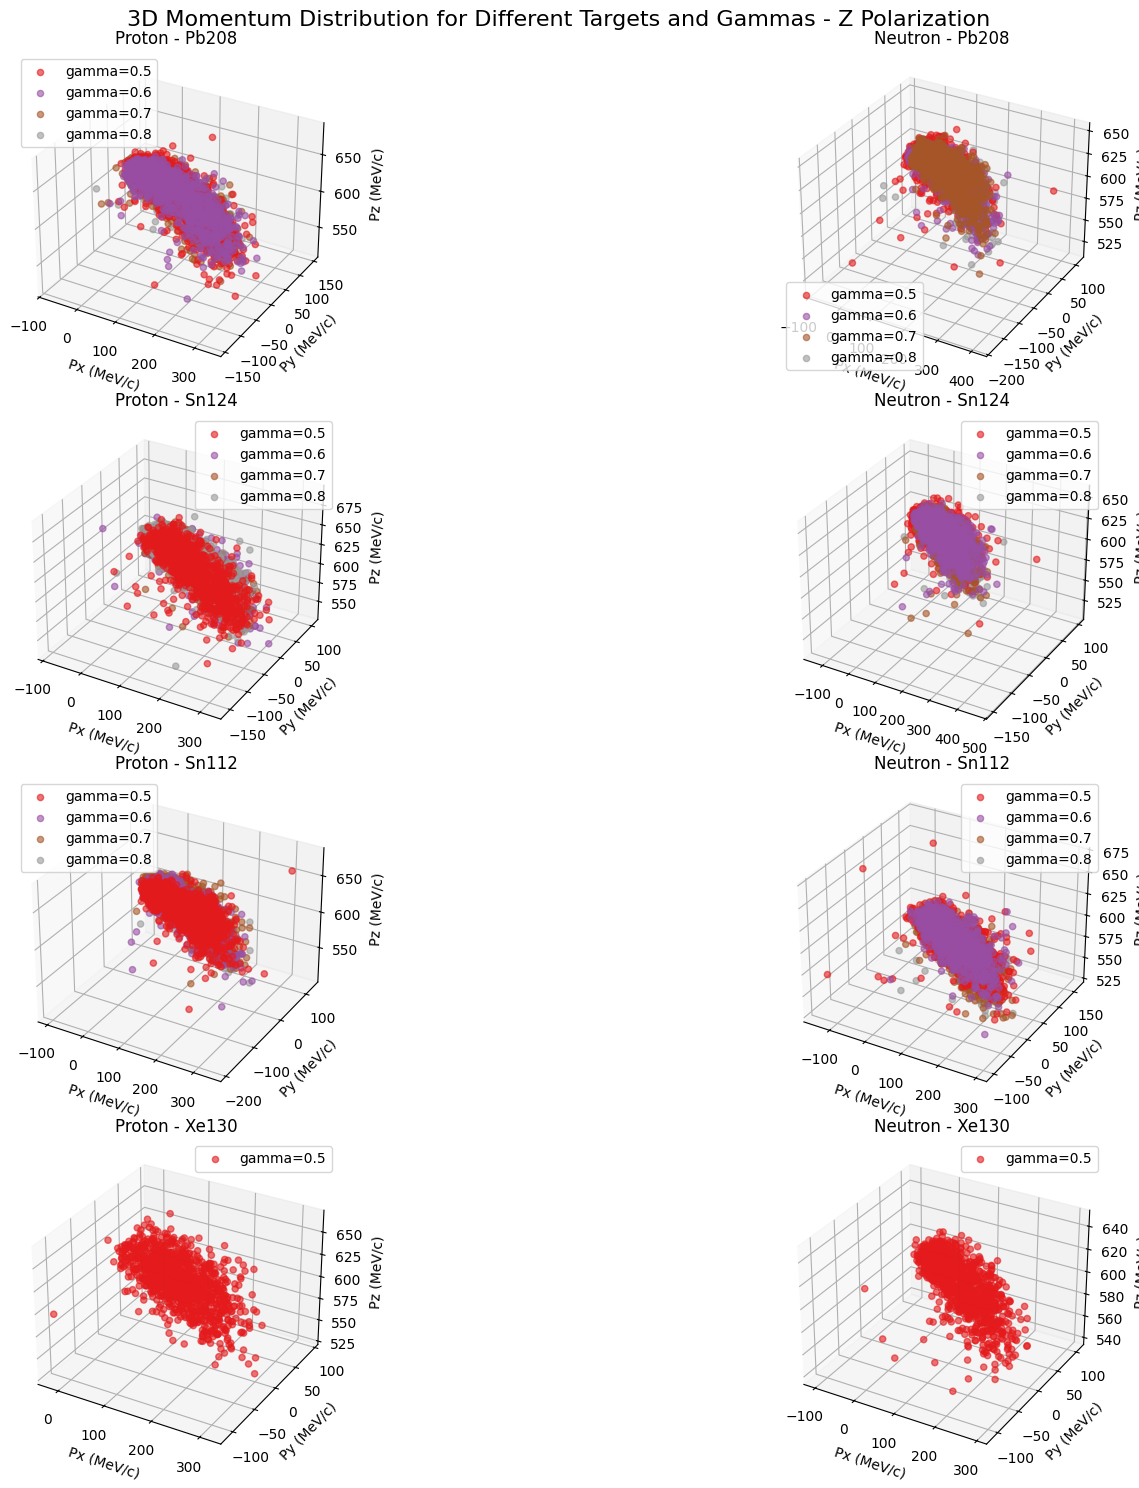

In [44]:
import matplotlib.pyplot as plt
# Plot 3D momentum distribution for different targets and gammas
def plot_3d_momentum_by_target_gamma():
    """Plot 3D momentum distribution for proton and neutron with different targets and gammas"""
    
    # Create large figure with all target and gamma subplots
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('3D Momentum Distribution for Different Targets and Gammas - Z Polarization', fontsize=16)
    
    # Set color mapping
    colors = plt.cm.Set1(np.linspace(0, 1, len(gammas)))
    gamma_labels = [0.5, 0.6, 0.7, 0.8]
    
    plot_idx = 1
    
    for target_idx, target in enumerate(targets):
        # Create proton and neutron 3D plots for each target
        
        # Proton 3D plot
        ax_p = fig.add_subplot(len(targets), 2, plot_idx, projection='3d')
        for gamma_idx, gamma in enumerate(gammas):
            px_data = momentum_data['proton'][target][gamma]['px']
            py_data = momentum_data['proton'][target][gamma]['py']
            pz_data = momentum_data['proton'][target][gamma]['pz']
            
            if len(px_data) > 0:
                # Random sampling to reduce points (if too many)
                if len(px_data) > 1000:
                    indices = np.random.choice(len(px_data), 1000, replace=False)
                    px_sample = [px_data[i] for i in indices]
                    py_sample = [py_data[i] for i in indices]
                    pz_sample = [pz_data[i] for i in indices]
                else:
                    px_sample, py_sample, pz_sample = px_data, py_data, pz_data
                
                ax_p.scatter(px_sample, py_sample, pz_sample, 
                           c=[colors[gamma_idx]], alpha=0.6, s=20,
                           label=f'gamma={gamma_labels[gamma_idx]}')
        
        ax_p.set_xlabel('Px (MeV/c)')
        ax_p.set_ylabel('Py (MeV/c)')
        ax_p.set_zlabel('Pz (MeV/c)')
        ax_p.set_title(f'Proton - {target}')
        ax_p.legend()
        plot_idx += 1
        
        # Neutron 3D plot
        ax_n = fig.add_subplot(len(targets), 2, plot_idx, projection='3d')
        for gamma_idx, gamma in enumerate(gammas):
            px_data = momentum_data['neutron'][target][gamma]['px']
            py_data = momentum_data['neutron'][target][gamma]['py']
            pz_data = momentum_data['neutron'][target][gamma]['pz']
            
            if len(px_data) > 0:
                # Random sampling to reduce points (if too many)
                if len(px_data) > 1000:
                    indices = np.random.choice(len(px_data), 1000, replace=False)
                    px_sample = [px_data[i] for i in indices]
                    py_sample = [py_data[i] for i in indices]
                    pz_sample = [pz_data[i] for i in indices]
                else:
                    px_sample, py_sample, pz_sample = px_data, py_data, pz_data
                
                ax_n.scatter(px_sample, py_sample, pz_sample, 
                           c=[colors[gamma_idx]], alpha=0.6, s=20,
                           label=f'gamma={gamma_labels[gamma_idx]}')
        
        ax_n.set_xlabel('Px (MeV/c)')
        ax_n.set_ylabel('Py (MeV/c)')
        ax_n.set_zlabel('Pz (MeV/c)')
        ax_n.set_title(f'Neutron - {target}')
        ax_n.legend()
        plot_idx += 1
    
    plt.tight_layout()
    plt.savefig('output/zpol_3d_momentum_by_target_gamma.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('output/zpol_3d_momentum_by_target_gamma.png', bbox_inches='tight', dpi=300)
    plt.show()

# Execute plotting
plot_3d_momentum_by_target_gamma()